# Lab 2 AutoML

<img src='https://github.com/retkowsky/images/blob/master/AzureMLservicebanniere.png?raw=true'>

In this example we use the associated credit card dataset to showcase how you can use AutoML for a simple classification problem. The goal is to predict if a credit card transaction is considered a fraudulent charge.

This notebook is using remote compute to train the model.

If you are using an Azure Machine Learning Compute Instance, you are all set. Otherwise, go through the [configuration](../../../configuration.ipynb) notebook first if you haven't already to establish your connection to the AzureML Workspace. 

In this notebook you will learn how to:
1. Create an experiment using an existing workspace.
2. Configure AutoML using `AutoMLConfig`.
3. Train the model using remote compute.
4. Explore the results.
5. Test the fitted model.

> Azure AutoML documentation :
https://docs.microsoft.com/en-us/azure/machine-learning/service/how-to-automated-ml

## Setup

As part of the setup you have already created an Azure ML `Workspace` object. For Automated ML you will need to create an `Experiment` object, which is a named object in a `Workspace` used to run experiments.

In [1]:
import sys
sys.version

'3.6.9 |Anaconda, Inc.| (default, Jul 30 2019, 19:07:31) \n[GCC 7.3.0]'

In [2]:
import datetime
now = datetime.datetime.now()
print('Date:', now)

Date: 2021-01-15 12:51:19.714750


In [3]:
import logging

from matplotlib import pyplot as plt
import pandas as pd
import os
import seaborn as sns

import azureml.core
from azureml.core.experiment import Experiment
from azureml.core.workspace import Workspace
from azureml.core.dataset import Dataset
from azureml.train.automl import AutoMLConfig

This sample notebook may use features that are not available in previous versions of the Azure ML SDK.

In [4]:
print("This notebook was created using version 1.20.0 of the Azure ML SDK")
print("You are currently using version", azureml.core.VERSION)

This notebook was created using version 1.20.0 of the Azure ML SDK
You are currently using version 1.20.0


In [5]:
ws = Workspace.from_config()

# choose a name for experiment
experiment_name = 'Lab2-AutoMLClassification'

experiment=Experiment(ws, experiment_name)

output = {}
output['Workspace'] = ws.name
output['Resource Group'] = ws.resource_group
output['Location'] = ws.location
output['Experiment Name'] = experiment.name
pd.set_option('display.max_colwidth', -1)
outputDf = pd.DataFrame(data = output, index = [''])
outputDf.T

,
Workspace,AMLworkshop
Resource Group,AMLworkshop-rg
Location,westeurope
Experiment Name,Lab2-AutoMLClassification


## Create or Attach existing AmlCompute
A compute target is required to execute the Automated ML run. In this tutorial, you create AmlCompute as your training compute resource.
#### Creation of AmlCompute takes approximately 2 minutes. 
If the AmlCompute with that name is already in your workspace this code will skip the creation process.
As with other Azure services, there are limits on certain resources (e.g. AmlCompute) associated with the Azure Machine Learning service. Please read [this article](https://docs.microsoft.com/en-us/azure/machine-learning/service/how-to-manage-quotas) on the default limits and how to request more quota.

In [6]:
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException

cpu_cluster_name = "automlcpucluster"


try:
    compute_target = ComputeTarget(workspace=ws, name=cpu_cluster_name)
    print('Found existing cluster, use it.')
except ComputeTargetException:
    compute_config = AmlCompute.provisioning_configuration(vm_size='STANDARD_DS12_V2',
                                                           vm_priority='dedicated',
                                                           min_nodes=0,
                                                           max_nodes=6,
                                                           idle_seconds_before_scaledown=14400)
    compute_target = ComputeTarget.create(ws, cpu_cluster_name, compute_config)

compute_target.wait_for_completion(show_output=True)

Found existing cluster, use it.
Succeeded
AmlCompute wait for completion finished

Minimum number of nodes requested have been provisioned


In [7]:
compute_target.provisioning_state

'Succeeded'

In [8]:
compute_target.serialize

<bound method AmlCompute.serialize of AmlCompute(workspace=Workspace.create(name='AMLworkshop', subscription_id='70b8f39e-8863-49f7-b6ba-34a80799550c', resource_group='AMLworkshop-rg'), name=automlcpucluster, id=/subscriptions/70b8f39e-8863-49f7-b6ba-34a80799550c/resourceGroups/AMLworkshop-rg/providers/Microsoft.MachineLearningServices/workspaces/AMLworkshop/computes/automlcpucluster, type=AmlCompute, provisioning_state=Succeeded, location=westeurope, tags=None)>

# Data

### Load Data

Load the credit card dataset from a csv file containing both training features and labels. The features are inputs to the model, while the training labels represent the expected output of the model. Next, we'll split the data using random_split and extract the training data for the model.

In [9]:
data = "https://raw.githubusercontent.com/retkowsky/Samples/master/GermanCreditRisk.csv"

dataset = Dataset.Tabular.from_delimited_files(data)
training_data, validation_data = dataset.random_split(percentage=0.8, seed=223)

label_column_name = 'Risk' # Variable à expliquer

In [10]:
df=dataset.to_pandas_dataframe()

In [11]:
df.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,moderate,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,moderate,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad


In [12]:
df.columns

Index(['Age', 'Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account',
       'Credit amount', 'Duration', 'Purpose', 'Risk'],
      dtype='object')

In [13]:
df.shape

(1000, 10)

In [14]:
df.Risk.value_counts()

good    700
bad     300
Name: Risk, dtype: int64

In [15]:
df.Risk.value_counts(normalize="true")

good    0.7
bad     0.3
Name: Risk, dtype: float64

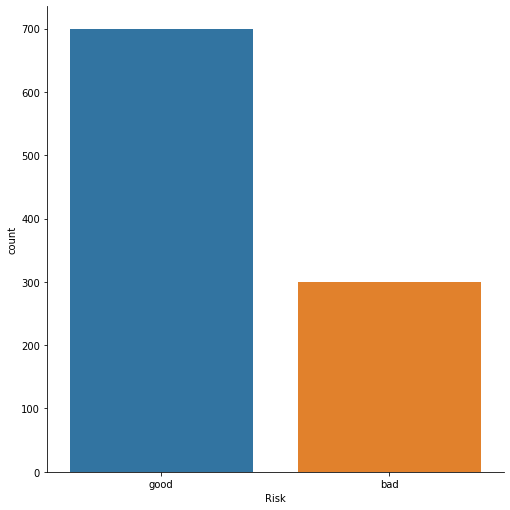

In [16]:
sns.catplot(x="Risk", kind="count", data=df, height=7)

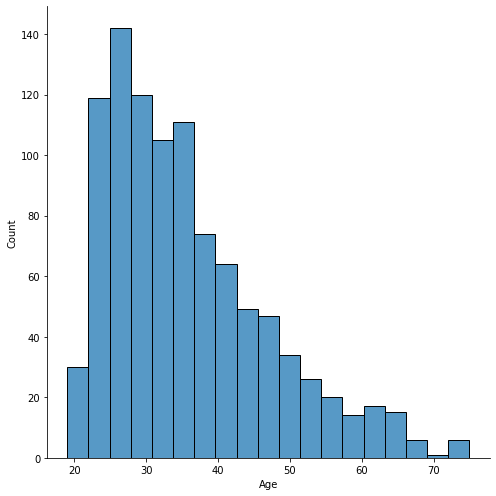

In [17]:
sns.displot(data=df, x="Age", height=7)

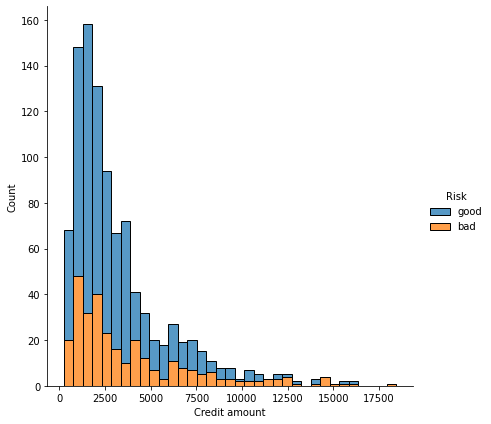

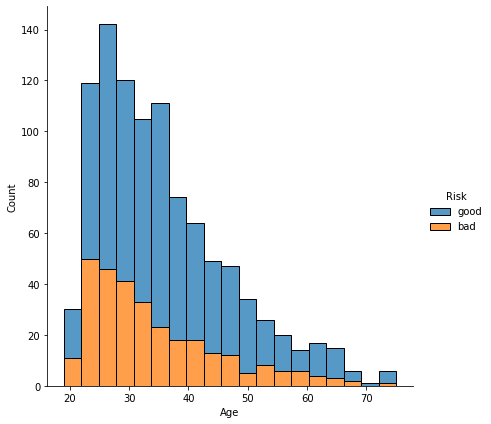

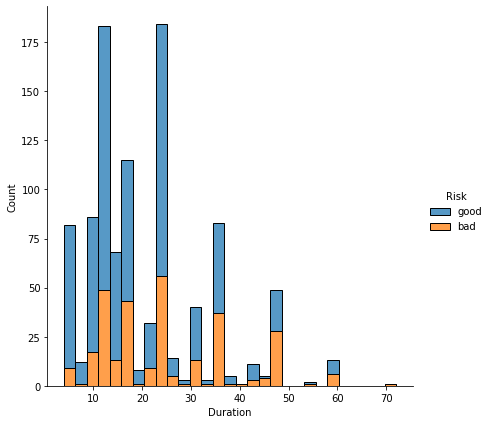

In [18]:
sns.displot(data=df, x="Credit amount", hue="Risk", multiple="stack", height=6)
sns.displot(data=df, x="Age", hue="Risk", multiple="stack", height=6)
sns.displot(data=df, x="Duration", hue="Risk", multiple="stack", height=6)

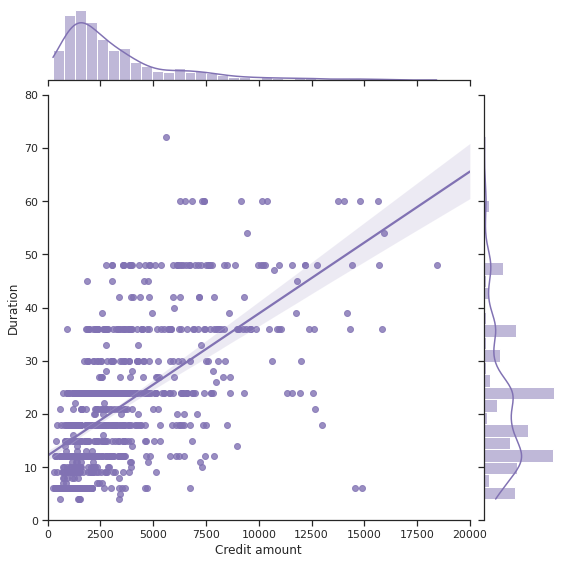

In [21]:
sns.set_theme(style="ticks")
g = sns.jointplot(x="Credit amount", y="Duration", data=df,
                  kind="reg", truncate=False,
                  xlim=(0, 20000), ylim=(0, 80), 
                  color="m", height=8)

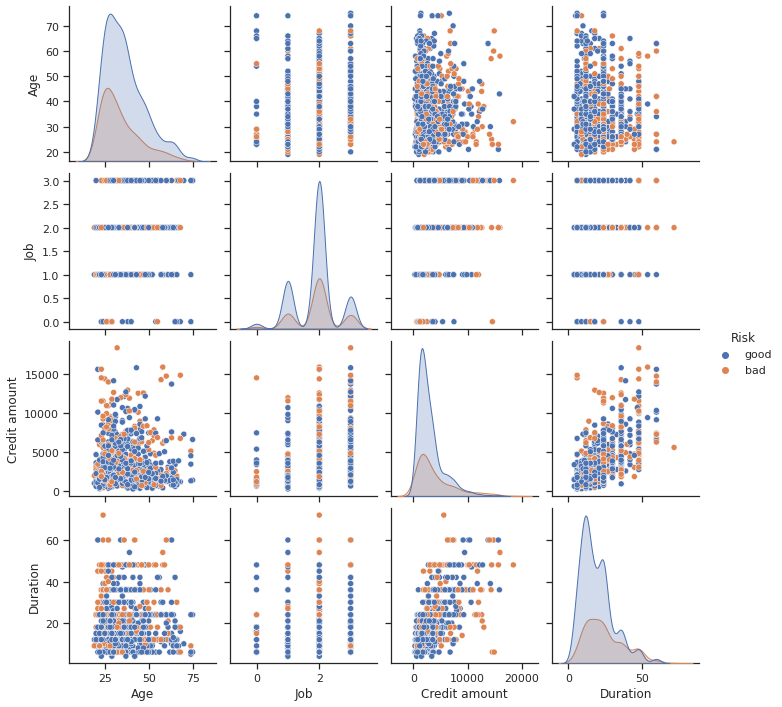

In [20]:
sns.set_theme(style="ticks")
sns.pairplot(df, hue="Risk")

## Let's save the dataset as an Azure ML dataset

In [22]:
tagsdataset= {"Type": "Test", 
              "Team": "DataScience",
              "Topic": "Fraude",
              "Pays": "France"}

In [23]:
dataset = dataset.register(workspace=ws,
                           name='CreditRiskDataset',
                           description='Credit Risk Dataset for AutoML',
                           create_new_version=True,
                           tags=tagsdataset)

In [24]:
dataset.name

'CreditRiskDataset'

In [25]:
dataset.tags

{'Type': 'Test', 'Team': 'DataScience', 'Topic': 'Fraud', 'Pays': 'France'}

## AutoML

Instantiate a AutoMLConfig object. This defines the settings and data used to run the experiment.


**_You can find more information about primary metrics_** [here](https://docs.microsoft.com/en-us/azure/machine-learning/service/how-to-configure-auto-train#primary-metric)

Documentation AutoMLConfig : https://docs.microsoft.com/en-us/python/api/azureml-train-automl-client/azureml.train.automl.automlconfig.automlconfig?view=azure-ml-py

In [27]:
automl_settings = {
    "n_cross_validations": 3,          # Validation croisée
    "primary_metric": 'accuracy',      # Métrique
    "iterations": 10,                  # Nombre itérations
    "max_concurrent_iterations": 2,    # Itérations concurrentes max
    "experiment_timeout_minutes": 15,  # Timeout full process
    "iteration_timeout_minutes": 5,    # Timeout par itération
    "enable_early_stopping": True, 
    "verbosity": logging.INFO,
    "featurization": 'auto',           # Data Engineering
    "enable_stack_ensemble": False,    # Pas de Stack ensemble
    "enable_voting_ensemble" : False,  # Pas de Vote ensemble
    }

automl_config = AutoMLConfig(task = 'classification',
                             debug_log = 'automl_errors.log',       # Log
                             blocked_models=['ExtremeRandomTrees'], # Liste de modèle(s) à exclure
                             compute_target = compute_target,       # Instance de calcul
                             training_data = training_data,         # Training dataset
                             label_column_name = label_column_name, # Target variable
                             **automl_settings                      # Options
                            )

Call the `submit` method on the experiment object and pass the run configuration. Depending on the data and the number of iterations this can run for a while. Validation errors and current status will be shown when setting `show_output=True` and the execution will be synchronous.

In [28]:
remote_run = experiment.submit(automl_config, show_output = True)

Running on remote.
No run_configuration provided, running on automlcpucluster with default configuration
Running on remote compute: automlcpucluster
Parent Run ID: AutoML_efe44e3d-8d97-4bb8-aaa3-1e33b53d7545

Current status: FeaturesGeneration. Generating features for the dataset.
Current status: DatasetCrossValidationSplit. Generating individually featurized CV splits.
Current status: ModelSelection. Beginning model selection.

****************************************************************************************************
DATA GUARDRAILS: 

TYPE:         Class balancing detection
STATUS:       PASSED
DESCRIPTION:  Your inputs were analyzed, and all classes are balanced in your training data.
              Learn more about imbalanced data: https://aka.ms/AutomatedMLImbalancedData

****************************************************************************************************

TYPE:         Missing feature values imputation
STATUS:       PASSED
DESCRIPTION:  No feature missing

In [29]:
remote_run.get_status

<bound method Run.get_status of Run(Experiment: Lab2-AutoMLClassification,
Id: AutoML_efe44e3d-8d97-4bb8-aaa3-1e33b53d7545,
Type: automl,
Status: Completed)>

In [30]:
remote_run

Experiment,Id,Type,Status,Details Page,Docs Page
Lab2-AutoMLClassification,AutoML_efe44e3d-8d97-4bb8-aaa3-1e33b53d7545,automl,Completed,Link to Azure Machine Learning studio,Link to Documentation


In [31]:
list_runs = experiment.get_runs()
for run in list_runs:
    print(run.id)

AutoML_efe44e3d-8d97-4bb8-aaa3-1e33b53d7545
AutoML_9ea9648f-80b9-46d3-9d24-cad808ebbdc1
AutoML_9d3c99a6-fc3f-42cc-9718-03f8756d5f13
AutoML_6bc13cc1-2e28-4508-97fb-a5b74beb7a20
AutoML_1bfb338e-9927-471d-a210-e17368b487e6


## Results

#### Widget for Monitoring Runs

The widget will first report a "loading" status while running the first iteration. After completing the first iteration, an auto-updating graph and table will be shown. The widget will refresh once per minute, so you should see the graph update as child runs complete.

**Note:** The widget displays a link at the bottom. Use this link to open a web interface to explore the individual run details

In [32]:
from azureml.widgets import RunDetails
RunDetails(remote_run).show()

_AutoMLWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', 's…

In [33]:
#remote_run.wait_for_completion(show_output=False)

#### Explain model

Automated ML models can be explained and visualized using the SDK Explainability library. 

## Analyze results

### Retrieve the Best Model

Below we select the best pipeline from our iterations. The `get_output` method returns the best run and the fitted model.  Overloads on `get_output` allow you to retrieve the best run and fitted model for *any* logged metric or for a particular *iteration*.

In [34]:
best_run, fitted_model = remote_run.get_output()
fitted_model

PipelineWithYTransformations(Pipeline={'memory': None,
                                       'steps': [('datatransformer',
                                                  DataTransformer(enable_dnn=None,
                                                                  enable_feature_sweeping=None,
                                                                  feature_sweeping_config=None,
                                                                  feature_sweeping_timeout=None,
                                                                  featurization_config=None,
                                                                  force_text_dnn=None,
                                                                  is_cross_validation=None,
                                                                  is_onnx_compatible=None,
                                                                  logger=None,
                                                              

#### Print the properties of the model
The fitted_model is a python object and you can read the different properties of the object.


## Test the fitted model

Now that the model is trained, split the data in the same way the data was split for training (The difference here is the data is being split locally) and then run the test data through the trained model to get the predicted values.

In [35]:
# convert the test data to dataframe
X_test_df = validation_data.drop_columns(columns=[label_column_name]).to_pandas_dataframe()
y_test_df = validation_data.keep_columns(columns=[label_column_name], validate=True).to_pandas_dataframe()

In [36]:
# call the predict functions on the model
y_pred = fitted_model.predict(X_test_df)
y_pred

array(['bad', 'good', 'good', 'bad', 'good', 'good', 'good', 'bad',
       'good', 'good', 'good', 'bad', 'good', 'good', 'good', 'good',
       'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good',
       'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good',
       'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good',
       'good', 'good', 'good', 'good', 'bad', 'good', 'good', 'good',
       'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good',
       'good', 'good', 'good', 'good', 'good', 'bad', 'good', 'good',
       'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good',
       'good', 'bad', 'good', 'good', 'good', 'good', 'good', 'good',
       'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good',
       'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good',
       'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good',
       'good', 'good', 'good', 'good', 'bad', 'good', 'good', 'good',
       'good',

### Calculate metrics for the prediction

Now visualize the data on a scatter plot to show what our truth (actual) values are compared to the predicted values 
from the trained model that was returned.

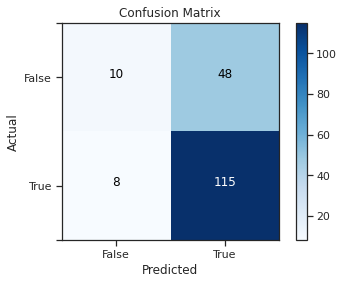

In [37]:
from sklearn.metrics import confusion_matrix
import numpy as np
import itertools

cf =confusion_matrix(y_test_df.values,y_pred)
plt.imshow(cf,cmap=plt.cm.Blues,interpolation='nearest')
plt.colorbar()
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
class_labels = ['False','True']
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks,class_labels)
plt.yticks([-0.5,0,1,1.5],['','False','True',''])
# plotting text value inside cells
thresh = cf.max() / 2.
for i,j in itertools.product(range(cf.shape[0]),range(cf.shape[1])):
    plt.text(j,i,format(cf[i,j],'d'),horizontalalignment='center',color='white' if cf[i,j] >thresh else 'black')
plt.show()

## All models

In [38]:
children = list(remote_run.get_children())
metricslist = {}
for run in children:
    properties = run.get_properties()
    metrics = {k: v for k, v in run.get_metrics().items() if isinstance(v, float)}
    metricslist[int(properties['iteration'])] = metrics

listemodeles = pd.DataFrame(metricslist).sort_index(1)
listemodeles

,0,1,2,3,4,5,6,7,8,9
average_precision_score_macro,0.66,0.67,0.69,0.67,0.66,0.68,0.65,0.66,0.68,0.69
f1_score_micro,0.71,0.72,0.73,0.71,0.68,0.66,0.71,0.70,0.70,0.73
weighted_accuracy,0.78,0.81,0.84,0.85,0.70,0.67,0.79,0.78,0.85,0.83
recall_score_micro,0.71,0.72,0.73,0.71,0.68,0.66,0.71,0.70,0.70,0.73
f1_score_macro,0.61,0.60,0.56,0.45,0.63,0.63,0.60,0.61,0.41,0.58
AUC_micro,0.77,0.78,0.79,0.79,0.73,0.72,0.77,0.77,0.79,0.79
average_precision_score_weighted,0.72,0.73,0.74,0.74,0.73,0.74,0.71,0.72,0.74,0.74
recall_score_macro,0.60,0.60,0.58,0.52,0.64,0.65,0.60,0.60,0.50,0.59
matthews_correlation,0.24,0.25,0.26,0.09,0.28,0.28,0.24,0.24,0.00,0.27
average_precision_score_micro,0.75,0.75,0.77,0.78,0.71,0.71,0.74,0.75,0.77,0.77


## Best Model

In [44]:
best_run, fitted_model = remote_run.get_output()
print("Best AutoML run =", best_run)

Best AutoML run = Run(Experiment: Lab2-AutoMLClassification,
Id: AutoML_efe44e3d-8d97-4bb8-aaa3-1e33b53d7545_2,
Type: azureml.scriptrun,
Status: Completed)


In [45]:
fitted_model.steps

[('datatransformer',
  DataTransformer(enable_dnn=None, enable_feature_sweeping=None,
                  feature_sweeping_config=None, feature_sweeping_timeout=None,
                  featurization_config=None, force_text_dnn=None,
                  is_cross_validation=None, is_onnx_compatible=None, logger=None,
                  observer=None, task=None, working_dir=None)),
 ('MaxAbsScaler', MaxAbsScaler(copy=True)),
 ('RandomForestClassifier',
  RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                         criterion='gini', max_depth=None, max_features='sqrt',
                         max_leaf_nodes=None, max_samples=None,
                         min_impurity_decrease=0.0, min_impurity_split=None,
                         min_samples_leaf=0.01,
                         min_samples_split=0.10368421052631578,
                         min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
                         oob_score=False, random_state=None,

In [46]:
print(fitted_model)

Pipeline(memory=None,
         steps=[('datatransformer',
                 DataTransformer(enable_dnn=None, enable_feature_sweeping=None,
                                 feature_sweeping_config=None,
                                 feature_sweeping_timeout=None,
                                 featurization_config=None, force_text_dnn=None,
                                 is_cross_validation=None,
                                 is_onnx_compatible=None, logger=None,
                                 observer=None, task=None, working_dir=None)),
                ('MaxAbsScaler', MaxAbsScaler(copy...
                 RandomForestClassifier(bootstrap=False, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='sqrt',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                   

In [47]:
fitted_model.get_params

<bound method PipelineWithYTransformations.get_params of PipelineWithYTransformations(Pipeline={'memory': None,
                                       'steps': [('datatransformer',
                                                  DataTransformer(enable_dnn=None,
                                                                  enable_feature_sweeping=None,
                                                                  feature_sweeping_config=None,
                                                                  feature_sweeping_timeout=None,
                                                                  featurization_config=None,
                                                                  force_text_dnn=None,
                                                                  is_cross_validation=None,
                                                                  is_onnx_compatible=None,
                                                                  logger=None,
     

In [48]:
print("Metrics of the best model:")
print()
best_run_metrics = best_run.get_metrics()
for metric_name in best_run_metrics:
    metric = best_run_metrics[metric_name]
    print('-', metric_name, '=', metric)

Metrics of the best model:

- f1_score_micro = 0.7301587301587302
- precision_score_macro = 0.749024663107043
- precision_score_micro = 0.7301587301587302
- log_loss = 0.5566449041593796
- AUC_micro = 0.79073917535456
- recall_score_macro = 0.5774575417386298
- AUC_weighted = 0.6994015362488066
- recall_score_weighted = 0.7301587301587302
- average_precision_score_macro = 0.6896749164153181
- matthews_correlation = 0.2613724974539757
- average_precision_score_weighted = 0.7442059473323144
- AUC_macro = 0.6994015362488066
- balanced_accuracy = 0.5774575417386298
- f1_score_macro = 0.5619825337031832
- average_precision_score_micro = 0.7705281156047938
- weighted_accuracy = 0.8394906527257889
- recall_score_micro = 0.7301587301587302
- precision_score_weighted = 0.7474965786819334
- f1_score_weighted = 0.6717336224085789
- accuracy = 0.7301587301587302
- norm_macro_recall = 0.15491508347725969
- confusion_matrix = aml://artifactId/ExperimentRun/dcid.AutoML_efe44e3d-8d97-4bb8-aaa3-1e33b53

## On peut prendre une itération

In [49]:
iteration = 8

my_run, my_model = remote_run.get_output(iteration = iteration)
print("Model",iteration," iteration :")
print(my_run)
print()
print(my_model)

Model 8  iteration :
Run(Experiment: Lab2-AutoMLClassification,
Id: AutoML_efe44e3d-8d97-4bb8-aaa3-1e33b53d7545_8,
Type: azureml.scriptrun,
Status: Completed)

Pipeline(memory=None,
         steps=[('datatransformer',
                 DataTransformer(enable_dnn=None, enable_feature_sweeping=None,
                                 feature_sweeping_config=None,
                                 feature_sweeping_timeout=None,
                                 featurization_config=None, force_text_dnn=None,
                                 is_cross_validation=None,
                                 is_onnx_compatible=None, logger=None,
                                 observer=None, task=None, working_dir=None)),
                ('MaxAbsScaler', MaxAbsScaler(copy...
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features=0.1,
                                        max_leaf_nodes=None, max_samples=None,
 

### On enregistre le meilleur modèle

In [50]:
best_run, fitted_model = remote_run.get_output()
print(best_run)
print()
print(fitted_model)
print()
print("Metrics:")
best_run_metrics = best_run.get_metrics()
for metric_name in best_run_metrics:
    metric = best_run_metrics[metric_name]
    print(metric_name, '=', metric)

Run(Experiment: Lab2-AutoMLClassification,
Id: AutoML_efe44e3d-8d97-4bb8-aaa3-1e33b53d7545_2,
Type: azureml.scriptrun,
Status: Completed)

Pipeline(memory=None,
         steps=[('datatransformer',
                 DataTransformer(enable_dnn=None, enable_feature_sweeping=None,
                                 feature_sweeping_config=None,
                                 feature_sweeping_timeout=None,
                                 featurization_config=None, force_text_dnn=None,
                                 is_cross_validation=None,
                                 is_onnx_compatible=None, logger=None,
                                 observer=None, task=None, working_dir=None)),
                ('MaxAbsScaler', MaxAbsScaler(copy...
                 RandomForestClassifier(bootstrap=False, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='sqrt',
                          

In [51]:
for step in fitted_model.named_steps:
    print(step)

datatransformer
MaxAbsScaler
RandomForestClassifier


In [52]:
from azureml.core import Model

best_run.register_model(model_path='outputs/model.pkl', 
                        model_name='BestAutoMLModel',
                        tags={'Training Context':'Azure Auto ML', 
                              'Compute Cluster':'Yes', 
                              'Topic':'Fraud Detection'},
                        properties={'AUC': best_run_metrics['AUC_weighted'], 
                                    'Average Precision Score': best_run_metrics['average_precision_score_weighted'],
                                    'Accuracy': best_run_metrics['accuracy'],
                                    'Precision': best_run_metrics['precision_score_weighted']}
                       )

Model(workspace=Workspace.create(name='AMLworkshop', subscription_id='70b8f39e-8863-49f7-b6ba-34a80799550c', resource_group='AMLworkshop-rg'), name=BestAutoMLModel, id=BestAutoMLModel:2, version=2, tags={'Training Context': 'Azure Auto ML', 'Compute Cluster': 'Yes', 'Topic': 'Fraud Detection'}, properties={'AUC': '0.6994015362488066', 'Average Precision Score': '0.7442059473323144', 'Accuracy': '0.7301587301587302', 'Precision': '0.7474965786819334'})

In [53]:
experiment

Name,Workspace,Report Page,Docs Page
Lab2-AutoMLClassification,AMLworkshop,Link to Azure Machine Learning studio,Link to Documentation


> You can open now the **Lab3 notebook**.

<img src="https://github.com/retkowsky/images/blob/master/Powered-by-MS-Azure-logo-v2.png?raw=true" height="300" width="300">